# Labeled Graphs
This example demonstrates how to define new C-Sets from existing C-Sets via the example of adding labels to a graph. We treat labels as members of an arbitrary FinSet of labels rather than a data attribute for pedagogical reasons. When you think of graphs where the labels are numbers, colors, or values of some kind, you would want to make them attributes. The motivation for this example is to be the simplest extension to the theory of graphs that you could possibly make.

In [1]:
using Catlab, Catlab.Theories
using Catlab.CategoricalAlgebra
using Catlab.Graphs
using Catlab.Graphics
using Colors
draw(g) = to_graphviz(g, node_labels=true, edge_labels=true)

draw (generic function with 1 method)

We start with the theory of graphs, which is copied from `Catlab.Graphs.BasicGraphs`. The two objects are the edges and vertices and we have two functions `src,tgt` that assign to every edge the source vertex and target vertex respectively. Functors from this category to Set (diagrams in Set of this shape) are category theoretic graphs (directed multigraphs).

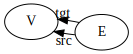

In [2]:
@present SchGraph(FreeSchema) begin
  V::Ob
  E::Ob
  src::Hom(E,V)
  tgt::Hom(E,V)
end

to_graphviz(SchGraph)

To the theory of graphs we want to add a set of labels `L` and map that assigns to every vertex to its label in `L`.

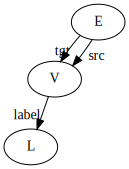

In [3]:
@present SchLGraph <: SchGraph begin
  L::Ob
  label::Hom(V,L)
end

to_graphviz(SchLGraph)

Catlab will automatically generate all the data structure and algorithms (storing, mutating, serializing, etc.) our `LGraphs` for us. This snippet declares that the Julia type `LGraph` should be composed of objects of the functor category `SchLGraph → Skel(FinSet)`, where `Skel(FinSet)` is the subcategory of Set containing finite sets of form `1:n`. We want our Julia type `LGraph` to inherit from the type `AbstractGraph` so that we can run graph algorithms on it. And we want the generated data structures to make an index of the maps `src`, `tgt`, and `label` so that looking up the in and outneighbors of vertex is fast and accessing all vertices by label is also fast.

**Note**: This schema differs from that of `LabeledGraph` in `Catlab.Graphs` by making the label type an object (`Ob`) rather than attribute type (`AttrType`). In this case, the set of labels can vary from instance to instance and homomorphisms can rename labels; in the other case, the set of labels is fixed by a Julia type, such as `Int` or `Symbol`, and label values must be strictly preserved homomorphisms. The graph theory literature does not always distinguish very carefully between these two cases.

In [4]:
@acset_type LGraph(SchLGraph, index=[:src,:tgt,:label]) <: AbstractGraph

Main.var"##327".LGraph

We need to tell Catlab how to convert our `LGraph` type into the normal `Graph` type by taking just the edges and vertices. This could be computed with Functorial Data Migration, but that is left for another sketch.

In [5]:
to_graph(g::LGraph) = begin
  h = Graph(nparts(g,:V))
  for e in edges(g)
    add_edge!(h, g[e, :src], g[e,:tgt])
  end
  return h
end

to_graph (generic function with 1 method)

Graphviz doesn't automatically know how we want to draw the labels, so we have to explicitly provide code that converts them to colors on the vertices. Note that we aren't calling these colored graphs, because that would imply some connectivity constraints on which vertices are allowed to be colored with the same colors. These labels are arbitrary, but we use color to visually encode them.

In [6]:
GraphvizGraphs.to_graphviz(g::LGraph; kw...) =
  to_graphviz(to_graphviz_property_graph(g; kw...))

function GraphvizGraphs.to_graphviz_property_graph(g::LGraph; kw...)
  h = to_graph(g)
  pg = to_graphviz_property_graph(h; kw...)
  vcolors = hex.(range(colorant"#0021A5", stop=colorant"#FA4616", length=nparts(g, :L)))
  for v in vertices(g)
    l = g[v, :label]
    set_vprops!(pg, v, Dict(:color => "#$(vcolors[l])"))
  end
  pg
end

draw(G::LGraph) = to_graphviz(G, node_labels=true, edge_labels=true)

draw (generic function with 2 methods)

Now we can start making some `LGraph` instances.

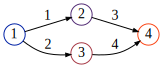

In [7]:
G = @acset LGraph begin
  V = 4
  E = 4
  L = 4
  src = [1,1,2,3]
  tgt = [2,3,4,4]
  label = [1,2,3,4]
end

draw(G)

The graph `G` has a 1-1 map between vertices and labels. That isn't necessary.

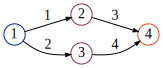

In [8]:
H = @acset LGraph begin
  V = 4
  E = 4
  L = 3
  src = [1,1,2,3]
  tgt = [2,3,4,4]
  label = [1,2,2,3]
end

draw(H)

We can look at some homomorphisms from G to H by their action on the labels or on the vertices.

In [9]:
homsᵥ(G,H) = map(α -> α[:V], homomorphisms(G, H))
homsₗ(G,H) = map(α -> α[:L], homomorphisms(G, H))

homsₗ (generic function with 1 method)

αₗ: G→ H

In [10]:
homsₗ(G,H)

4-element Vector{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}:
 FinFunction([1, 2, 2, 3], 4, 3)
 FinFunction([1, 2, 2, 3], 4, 3)
 FinFunction([1, 2, 2, 3], 4, 3)
 FinFunction([1, 2, 2, 3], 4, 3)

αᵥ: G→ H

In [11]:
homsᵥ(G,H)

4-element Vector{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}:
 FinFunction([1, 2, 2, 4], 4, 4)
 FinFunction([1, 2, 3, 4], 4, 4)
 FinFunction([1, 3, 2, 4], 4, 4)
 FinFunction([1, 3, 3, 4], 4, 4)

Note that if we reverse the direction of our homomorphism search, we get fewer matches even though the two `LGraph`s are isomorphic as graphs. The fact that in `H` vertex two and three are the same label means we have to send them to the same vertex in `G`.

In [12]:
homsᵥ(H,G)

2-element Vector{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}:
 FinFunction([1, 2, 2, 4], 4, 4)
 FinFunction([1, 3, 3, 4], 4, 4)

We can build some bigger examples like A.

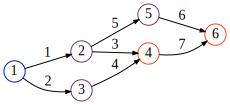

In [13]:
A = @acset LGraph begin
  V = 6
  E = 7
  L = 3
  src = [1,1,2,3,2,5,4]
  tgt = [2,3,4,4,5,6,6]
  label = [1,2,2,3,2,3]
end
draw(A)

and B.

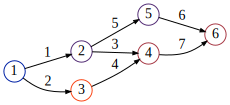

In [14]:
B = @acset LGraph begin
  V = 6
  E = 7
  L = 4
  src = [1,1,2,3,2,5,4]
  tgt = [2,3,4,4,5,6,6]
  label = [1,2,4,3,2,3]
end
draw(B)

The morphisms from A to B and B to A are also different, showing how the labels affect the structure in this category.

In [15]:
homsᵥ(A,B)

1-element Vector{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}:
 FinFunction([1, 2, 2, 4, 5, 6], 6, 6)

There are more morphisms from B to A than A to B.

In [16]:
homsᵥ(B,A)

2-element Vector{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}:
 FinFunction([1, 2, 2, 4, 5, 6], 6, 6)
 FinFunction([1, 2, 3, 4, 5, 6], 6, 6)

There are two automorphisms on A

In [17]:
homsᵥ(A,A)

2-element Vector{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}:
 FinFunction([1, 2, 2, 4, 5, 6], 6, 6)
 FinFunction([1, 2, 3, 4, 5, 6], 6, 6)

And two automorphisms on B

In [18]:
homsᵥ(B,B)

2-element Vector{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}:
 FinFunction([1, 2, 2, 4, 5, 6], 6, 6)
 FinFunction([1, 2, 3, 4, 5, 6], 6, 6)

But if we forget about the labels and look at the automorphisms of the underlying graph, we get more automorphisms!

In [19]:
A₀ = to_graph(A)
homsᵥ(A₀, A₀)

8-element Vector{Catlab.CategoricalAlgebra.FinSets.FinDomFunctionVector{Int64, Vector{Int64}, Catlab.CategoricalAlgebra.FinSets.FinSetInt}}:
 FinFunction([1, 2, 2, 4, 4, 6], 6, 6)
 FinFunction([1, 2, 2, 4, 5, 6], 6, 6)
 FinFunction([1, 2, 2, 5, 4, 6], 6, 6)
 FinFunction([1, 2, 2, 5, 5, 6], 6, 6)
 FinFunction([1, 2, 3, 4, 4, 6], 6, 6)
 FinFunction([1, 2, 3, 4, 5, 6], 6, 6)
 FinFunction([1, 3, 2, 4, 4, 6], 6, 6)
 FinFunction([1, 3, 3, 4, 4, 6], 6, 6)

## Limits and Composition by Multiplication
Catlab has an implementation of limits for any C-Sets over any schema. So, we can just ask about labeled graphs. Notice that we get more distinct colors in the product than in either initial graph. This is because the labels of the product are pairs of labels from the factors. If `G` has `n` colors and `H` has `m` colors `G×H` will have `n×m` colors.

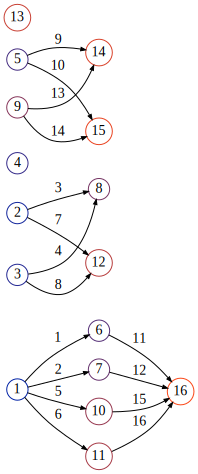

In [20]:
draw(apex(product(G,G)))

The graph above looks weirdly disconnected and probably wasn't what you expected to see as the product. When we compose with products, we often want to add the reflexive edges in order to get the expected notion of product.

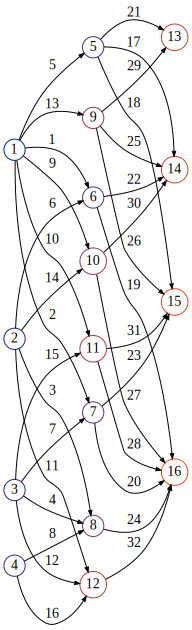

In [21]:
add_loops!(G::LGraph) = begin
  for v in parts(G,:V)
    add_edge!(G, v,v)
  end
  return G
end
add_loops(G::LGraph) = add_loops!(copy(G))

Gᵣ = add_loops(G)
P = apex(product(Gᵣ, G))
draw(apex(product(Gᵣ, G)))

We can look at the shape of commuting triangle, which is our favorite 3-vertex graph.

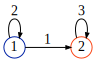

In [22]:
T = @acset LGraph begin
  V = 3
  E = 3
  L = 3
  src = [1,1,2]
  tgt = [2,3,3]
  label = [1,2,3]
end
Tᵣ = add_loops(T)
draw(Tᵣ)

E = @acset LGraph begin
  V = 2
  E = 1
  L = 2
  src = [1]
  tgt = [2]
  label = [1,2]
end
Eᵣ = add_loops(E)
draw(Eᵣ)

We can draw the product of the edge graph and the triangle graph to get the shape of a triangular prism. You can view this product as extruding `Tᵣ` along `Eᵣ`. Catlab provides a `ReflexiveGraph` as a type that handles these self-loops more intelligently than we are here. Graphviz struggles with the layout here because the product graph will include edges that are a step in both directions. This [blog post](https://www.algebraicjulia.org/blog/post/2021/04/cset-graphs-3/) does a good job explaining products in differnt kinds of graph categories.

In [23]:
draw(apex(product(Tᵣ,Eᵣ)))
legs(product(Tᵣ, Eᵣ))[1][:V] |> collect

6-element Vector{Int64}:
 1
 2
 3
 1
 2
 3

Another limit is the pullback. If you have a cospan, which is a diagram of the shape `X ⟶ A ⟵ Y`, you can pull back one arrow along the other by solving a system of equations.

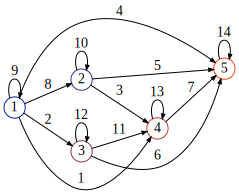

In [24]:
PB₂₂ = pullback(homomorphisms(Tᵣ,Eᵣ)[2],homomorphisms(Tᵣ,Eᵣ)[2]);
draw(apex(PB₂₂))

Note that the pullback depends not only on X,A,Y but also on the two arrows. You can play around with the choice of morphisms to gain an intuition of how the pullback depends on the morphisms.

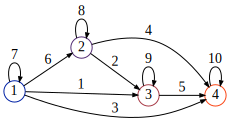

In [25]:
PB₂₃ = pullback(homomorphisms(Tᵣ,Eᵣ)[2],homomorphisms(Tᵣ,Eᵣ)[3]);
draw(apex(PB₂₃))

By constructions, the pullback is always a subobject (monic homomorphism) into the product. Catlab can enumerate all such monoic homs.

In [26]:
homomorphisms(apex(PB₂₂), apex(product(Tᵣ,Tᵣ)), monic=true) |> length

34

## Colimits and Composition by Glueing
The dual concept to limits is colimits and if limits have vibes of taking all pairs that satisfy certain constraints, colimits have the vibes of designers just gluing stuff together to make it work.

In order to illustrate this we will be gluing triangles together to make a mesh. We start by defining the point `X`, which is the shape of the boundary along which we will glue and the morphism `ℓ₁`, which is the place in `T` that we consider as the boundary.

In [27]:
X = @acset LGraph begin
  E = 0
  V = 1
  L = 3
  label=[2]
end
ℓ₁ = ACSetTransformation(X,T, V=[2],L=1:3)
draw(X)

We have to check that the morphism is valid before we go and compute out pushout.

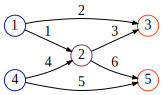

In [28]:
is_natural(ℓ₁)
P = pushout(ℓ₁, ℓ₁)
draw(apex(P))

Now we want to repeat the gluing process to get a bigger mesh. So we are going to need a bigger interface.

In [29]:
I = @acset LGraph begin
  V = 2
  L = 3
  label = [1,1]
end
draw(I)

We have to specify how this interface embeds into both of the things we want to glue. In this case we are gluing a copy of `P` onto itself.

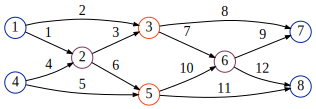

In [30]:
ll = ACSetTransformation(I, apex(P), V=[3,5], L =[3,1,2])
is_natural(ll)
lr = ACSetTransformation(I, apex(P), V=[1,4], L =[1,3,2])
is_natural(lr)
P₂ = pushout(ll, lr);
draw(apex(P₂))